<a href="https://www.kaggle.com/code/clemwo/xai-series-dimensionality-reduction?scriptVersionId=215438187" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

✨✨This notebook is part of my 📡 **Explainable AI (XAI) Series** 🕵️‍♂️, where I explore techniques that make machine learning models and processes more transparent and interpretable. In this series, I focus on methods that not only improve model performance but also provide insights into how and why models make decisions.

In [1]:
%pip install umap
%pip install umap-learn

  Preparing metadata (setup.py) ... - \ done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=874d66ef69c67d8724e98846313d969c89cafa3359de04b40af6948b4018a212
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates
from matplotlib.colors import LinearSegmentedColormap
from itertools import combinations

np.random.seed(42)  # For reproduciobility

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/kaggle/input/high-dimensional-datascape/all_data.csv


---

# 🧠XAI Series 🕵️‍♂️ Dimensionality Reduction🔄

In this notebook, we explore [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) techniques using Kaggle's [High Dimensional Datascape](https://www.kaggle.com/datasets/krishd123/high-dimensional-datascape/data) dataset. With its large number of features, this dataset is ideal for understanding and comparing methods that simplify high-dimensional data while retaining meaningful information.

We will analyze and visualize the following key techniques:
1. 📊***Principal Component Analysis (PCA)***:
   <span style="color:black">A linear technique that projects data onto orthogonal axes of maximum variance, often used for visualization and preprocessing.</span>
3. 🌀***t-Distributed Stochastic Neighbor Embedding (t-SNE)***:
   <span style="color:black">A non-linear, probabilistic technique primarily for visualizing high-dimensional data in 2D or 3D space while preserving local structure.</span>
5. 🌐***Uniform Manifold Approximation and Projection (UMAP)***:
   <span style="color:black">A non-linear method that balances local and global structure preservation, offering faster and more scalable alternatives to t-SNE.</span>
7. ***Linear Discriminant Analysis (LDA)***:
   <span style="color:black">Supervised linear reduction for maximizing class separability.</span>

To investigate and understand the differences between these methods, we will:
- **Compare and visualize results** to identify how each technique reduces dimensionality.
- **Analyze when to use linear vs. non-linear methods** based on the data's characteristics and objectives.

By the end of this notebook, you will gain hands-on experience applying and evaluating various dimensionality reduction techniques to simplify complex datasets while maintaining insights critical for analysis and interpretation.

In [3]:
data = pd.read_csv('/kaggle/input/high-dimensional-datascape/all_data.csv')
print(f"Rows: {data.shape[0]:,}")
print(f"Cols: {data.shape[1]:,}")
data.head()

Rows: 230
Cols: 537


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 527,Unnamed: 528,Unnamed: 529,Unnamed: 530,Unnamed: 531,Unnamed: 532,Unnamed: 533,Unnamed: 534,Unnamed: 535,Label
0,-0.000133,0.000262,0.001099,0.001834,0.002109,0.002223,0.002233,0.002036,0.001582,0.000969,...,0.82953,2.9079,3.7557,1.3344,0.74247,0.22507,0.56249,1.5705,0.79906,0
1,-0.000842,-0.001011,-0.001071,-0.000944,-0.000794,-0.000610,-0.000445,-0.000173,0.000077,0.000285,...,0.84335,3.0110,3.9877,1.2461,0.74423,0.22567,0.61034,1.6645,0.74574,0
2,-0.000766,-0.000535,0.000162,0.000898,0.001287,0.001582,0.001704,0.001659,0.001574,0.001438,...,0.87413,3.0613,3.9749,1.1560,0.52508,0.19934,0.45707,1.3386,0.74574,0
3,-0.000301,-0.000377,-0.000451,-0.000529,-0.000685,-0.000845,-0.000899,-0.000822,-0.000550,-0.000182,...,0.85467,3.3337,3.9205,1.3341,0.46024,0.20031,0.45924,1.7969,0.32451,0
4,-0.000589,-0.000857,-0.001135,-0.001171,-0.001128,-0.001039,-0.000959,-0.000937,-0.000916,-0.000819,...,0.82978,3.5814,3.7667,1.1151,0.44572,0.20538,0.41882,1.4422,0.32451,0


Except the target column `Label`, all columns are called with `Unnamed` in their name. We rename them for convenience.

In [4]:
data.columns = [f"Feature_{i+1}" for i in range(data.shape[1]-1)] + ['Label']
data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_528,Feature_529,Feature_530,Feature_531,Feature_532,Feature_533,Feature_534,Feature_535,Feature_536,Label
0,-0.000133,0.000262,0.001099,0.001834,0.002109,0.002223,0.002233,0.002036,0.001582,0.000969,...,0.82953,2.9079,3.7557,1.3344,0.74247,0.22507,0.56249,1.5705,0.79906,0
1,-0.000842,-0.001011,-0.001071,-0.000944,-0.000794,-0.000610,-0.000445,-0.000173,0.000077,0.000285,...,0.84335,3.0110,3.9877,1.2461,0.74423,0.22567,0.61034,1.6645,0.74574,0
2,-0.000766,-0.000535,0.000162,0.000898,0.001287,0.001582,0.001704,0.001659,0.001574,0.001438,...,0.87413,3.0613,3.9749,1.1560,0.52508,0.19934,0.45707,1.3386,0.74574,0
3,-0.000301,-0.000377,-0.000451,-0.000529,-0.000685,-0.000845,-0.000899,-0.000822,-0.000550,-0.000182,...,0.85467,3.3337,3.9205,1.3341,0.46024,0.20031,0.45924,1.7969,0.32451,0
4,-0.000589,-0.000857,-0.001135,-0.001171,-0.001128,-0.001039,-0.000959,-0.000937,-0.000916,-0.000819,...,0.82978,3.5814,3.7667,1.1151,0.44572,0.20538,0.41882,1.4422,0.32451,0


Now we have 536 clean named columns `Feature_1`, ..., `Feature_536` and one target column `Label`. This dataset contains a large number of features, but not all of them likely hold meaningful information. To simplify the data and uncover its key patterns, we will now apply dimensionality reduction techniques. 📉✨

# 🌍Global Variables

In [5]:
RANDOM_STATE = 42

GREEN = '#057a76'
BLUE = '#0172c3'
RED = '#d63c7f'
VIOLET = '#8d46fb'
BROWN = '#ba4e00'

LIGHT_GREEN = '#6fc9c7'
LIGHT_BLUE = '#76bff1'
LIGHT_RED = '#f6aecd'
LIGHT_VIOLET = '#c9a9ff'
LIGHT_BROWN = '#f6b88d'

# 📊PCA

⚡**TL;DR**⚡
> ***<span style="color:#ba4e00">Principal Component Analysis</span>*** = PCA
- Focus is on capturing global linear relationships in the data. 
- Should be used to simplify and find global linear relationships and patterns in the data.

🔍**More Specifically**🔍

[PCA](https://scikit-learn.org/1.5/modules/generated/sklearn.decomposition.PCA.html) is a **linear dimensionality reduction technique** that helps simplify high-dimensional data by projecting it onto a lower-dimensional space. It does so while retaining as much information (variance) as possible.

In the context of **Explainable AI (XAI)**, PCA is particularly valuable because it can:
- **Reduce complexity** in models without significant loss of information.
- **Visualize high-dimensional data** in 2D or 3D, making it easier for humans to interpret patterns.
- **Identify key features** or directions (principal components) that explain the most variance in the data.

In [6]:
from sklearn.decomposition import PCA

We start with investigating 2 principal components (PCs) and then continue with techniques for 3 and more PCs. 

In [7]:
N_COMPONENTS = 2

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=N_COMPONENTS)
pca_result = pca.fit_transform(data_scaled)

## How PCA Works & The Mathematics Behind It🧩🧮 
**Objective**
> PCA reduces the dimensionality of data while retaining *as much variance as possible*. It finds axes (*principal components*) that are linear combinations of the original features.  

The steps of PCA are: 

1️⃣ **Standardize the Data**:
    - Since PCA is sensitive to scale, the data is standardized so that each feature has a mean of 0 and unit variance.

Ensure that each feature has zero mean and unit variance:
$$
    z_{ij} = \frac{x_{ij} - \mu_{ij}}{\sigma_{ij}}
$$
- $x_{ij}$: Original value
- $\mu_{ij}$: Mean of features $j$
- $\sigma_{ij}$: Standard deviation of feature $j$

2️⃣ **Compute the Covariance Matrix**:
    - PCA computes the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) of the features to understand how they vary with each other.

The covariance matrix $C$ captures relationships between features:
$$  
    C = \frac{1}{n-1}Z^TZ
$$
- $Z$: Standardized data matrix (rows=samples, columns=features)
- $C$: Symmetric $d \times d$ covariance matrix

3️⃣ **Eigen Decomposition of the Covariance Matrix**:
    - Eigenvectors represent the directions (principal components) in which the data varies the most.
    - Eigenvalues represent the magnitude of variance explained by each principal component.

Solve for [eigenvalues](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) $\lambda$ and [eigenvectors](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) $v$ of the covariance matrix $C$:
$$  
    Cv = \lambda v
$$
- **Eigenvextors** represent the directions (principal components = PC) in which the data varies the most. Or differently said, they are the principle directions = *axes of maximum variance*.
- **Eigenvalues** represent the magnitude of variance explained by PC. Or differenty said, they capture the *magnitude of variance* along each principle direction.

4️⃣ **Sort & Select Top Components**:
    1. Sort eigenvalues $\lambda$ in descending order.
    2. Select the top $k$ eigenvectors $v$ (principle components).

5️⃣ **Project Data onto Principal Components:**
    - The data is then projected onto the principal components in descending order of explained variance. The first component captures the most variance, the second captures the next most, and so on.

Transform the original data $X$ into the new lower-dimensional space:
$$
    Z_{\text{reduced}} = ZW_k
$$
- $Z$: Standardized data matrix
- $W_k$: Matrix of top $k$ eigenvectors
- $Z_{\text{reduced}}$: Projected data in $k$-dimensional space

There are some **key concepts** one should keep in mind.
- **Variance Explained**: Each eigenvalue $\lambda_i$ represents the variance explained by its corresponding PC.
- **Cumulative Variance**: $\text{Cumulative Variance} = \frac{\sum_{i=1}^{k} \lambda_i}{\sum_{j=1}^{d} \lambda_j}$
- **Dimensionality Reduction**: Retain $k$ components such that the cumulative variance exceeds a threshold (e.g. $95\%$)

## Visualization Techniques🔍

In [8]:
pca_df = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"])

First, we visualize and observe the explained variance.

***<span style="color:#ba4e00">Explained Variance Plot</span>***:
Shows how much variance each principal component captures, which helps to decide how many components to retain.

It can tell the raw amount of variance captured by each principal component in the original scale of the data. Or it can tell the explained variance ratio which is normalized and shows how much percentage the data’s overall variability each principal component captures relative to others. This helps us decide how many components to keep (e.g., selecting enough components to explain 95% of the variance).

In [9]:
total_explained_variance_percentage = sum(pca.explained_variance_ratio_)
print(f"The PCA has accounted for {100*total_explained_variance_percentage:.2f}% of the total variance in the dataset.")

The PCA has accounted for 13.23% of the total variance in the dataset.


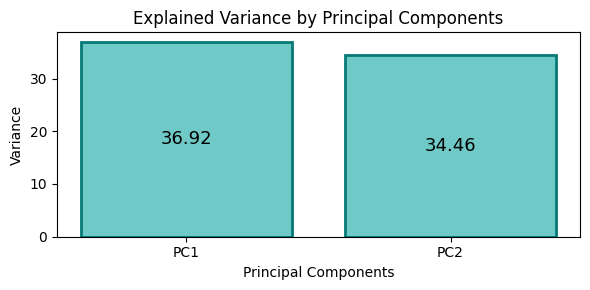

In [10]:
explained_variance = pca.explained_variance_

fig, axs = plt.subplots(figsize=(6, 3))

bars = axs.bar(
    x=["PC1", "PC2"], 
    height=explained_variance, 
    color=LIGHT_GREEN, 
    edgecolor=GREEN,
    linewidth=2.0
)

for bar, value in zip(bars, explained_variance):
    height = bar.get_height()
    axs.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{value:.2f}",
        ha='center',
        va='center',
        fontsize=13,
        color='black'
    )

axs.set_title("Explained Variance by Principal Components")
axs.set_ylabel("Variance")
axs.set_xlabel("Principal Components")

plt.tight_layout()
plt.show()

PC1 explains slightly more variance (36.92) compared to PC2 (34.46), indicating that both components contribute almost equally to capturing the data's variability. Since the explained variance is essentially the eigenvalue for the specific component, the eigenvalues $\lambda_i$ are:
$$
\begin{align}
    \text{Explained Variance for PC1} = \mathbb{V}_{\text{Explained}}^1 = \lambda_1 = 36.92 \\
    \text{Explained Variance for PC2} = \mathbb{V}_{\text{Explained}}^2 = \lambda_2 = 34.46
\end{align}    
$$

Let's investigate how the explained variance changes when we increase the number of PCs.

In [11]:
for n_components in range(1, 41):
    pca = PCA(n_components=n_components)
    pca.fit_transform(data_scaled)
    total_explained_variance_percentage = sum(pca.explained_variance_ratio_) * 100

    print(f"{n_components:2} PCs: {total_explained_variance_percentage:>2.2f}% variance explained")

 1 PCs: 6.84% variance explained
 2 PCs: 13.23% variance explained
 3 PCs: 19.28% variance explained
 4 PCs: 24.70% variance explained
 5 PCs: 30.08% variance explained
 6 PCs: 35.08% variance explained
 7 PCs: 39.65% variance explained
 8 PCs: 44.14% variance explained
 9 PCs: 48.34% variance explained
10 PCs: 52.49% variance explained
11 PCs: 56.31% variance explained
12 PCs: 59.84% variance explained
13 PCs: 63.23% variance explained
14 PCs: 66.42% variance explained
15 PCs: 69.33% variance explained
16 PCs: 72.18% variance explained
17 PCs: 74.81% variance explained
18 PCs: 77.28% variance explained
19 PCs: 79.57% variance explained
20 PCs: 81.74% variance explained
21 PCs: 83.73% variance explained
22 PCs: 85.47% variance explained
23 PCs: 87.17% variance explained
24 PCs: 88.62% variance explained
25 PCs: 89.97% variance explained
26 PCs: 91.14% variance explained
27 PCs: 92.25% variance explained
28 PCs: 93.18% variance explained
29 PCs: 94.00% variance explained
30 PCs: 94.63% 

We visualize the explained variance ratio per number of PCs. Horizontally we emphasize the percentages 50%, 80% and 90%.

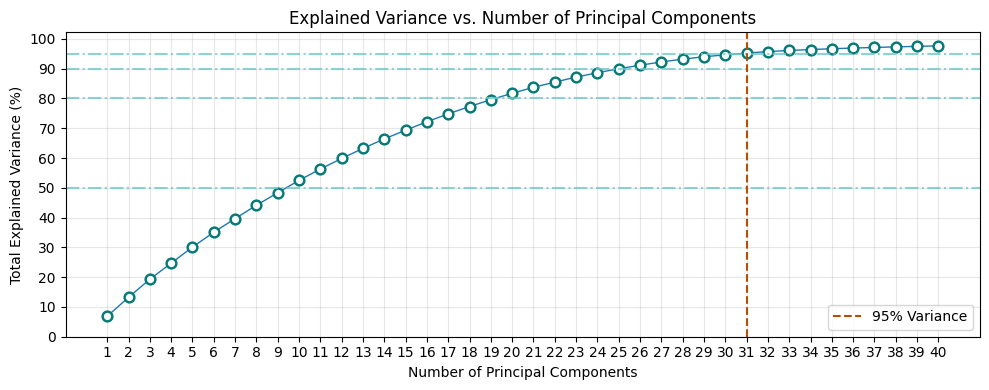

In [12]:
explained_variance_percentages = []
components_range = range(1, 41)

for n_components in components_range:
    pca = PCA(n_components=n_components)
    pca.fit(data_scaled)
    total_explained_variance_percentage = sum(pca.explained_variance_ratio_) * 100
    explained_variance_percentages.append(total_explained_variance_percentage)

plt.figure(figsize=(10, 4))
plt.plot(components_range, explained_variance_percentages, 
         mec=GREEN, mfc='white', markersize=7, marker='o',
         markeredgewidth=1.75, linestyle='-', linewidth=1.0)
plt.title("Explained Variance vs. Number of Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Total Explained Variance (%)")
plt.xticks(components_range)
plt.yticks(np.arange(0, 101, 10))

plt.grid(alpha=0.3)
for perc_explained_variance in [50, 80, 90, 95]: 
    plt.axhline(perc_explained_variance, color=LIGHT_GREEN, linestyle='-.', linewidth=1.5, alpha=0.8)

pc_95 = next((i + 1 for i, value in enumerate(explained_variance_percentages) if value > 95), None)
if pc_95:
    plt.axvline(pc_95, color=BROWN, linestyle='--', linewidth=1.5, label=f'95% Variance')

plt.legend()
plt.tight_layout()
plt.show()

In [13]:
print(f"To explain 95% of the total variance, {pc_95} principal components are required.")
print(f"This represents {100 * pc_95 / (data.shape[1] - 1):.2f}% of the original {data.shape[1] - 1} columns.")

To explain 95% of the total variance, 31 principal components are required.
This represents 5.78% of the original 536 columns.


We observe that 
- We need 10 PCs to explain more than 50% of the total variance
- We need 20 PCs to explain more than 80% of the total variance
- We need 26 PCs to explain more than 90% of the total variance
- We need 31 PCs to explain more than 95% of the total variance

🎯🎯*A common rule of thumb is to retain enough PCs to capture 95% of the total variance*🎯🎯

For our dataset this would mean that **we need 31 Principal Components to explain more than 95% of the total variance**. 

Now back to two PCs. There are difference visualization techniques we can use.

***<span style="color:#ba4e00">Scatter Plot</span>*** (PC1 vs PC2): Visualizes the data reduced to the number of dimensions, in our case, two. Now the patterns and relationships in the original high-dimensional data are easier to interpret.

Note that for this example we choose $2$ as the number of dimensions. This can be changed by the user of the technique depending on how dimensions the dataset should be reduces to. 

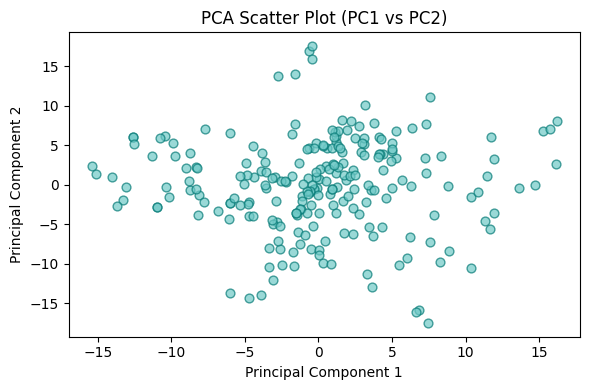

In [14]:
fig, axs = plt.subplots(figsize=(6, 4))

axs.scatter(pca_df["PC1"], pca_df["PC2"], 
            s=40, c=LIGHT_GREEN, alpha=0.7, edgecolors=GREEN)
axs.set_title("PCA Scatter Plot (PC1 vs PC2)")
axs.set_xlabel("Principal Component 1")
axs.set_ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

Now, we will incrase the number of components and try out techniques to visualize them. We start by using the scatter plot in 3D. However, note that a scatter plot is only feasibly for 2 or 3 components. For higher numbers of components different techniques need to be used.

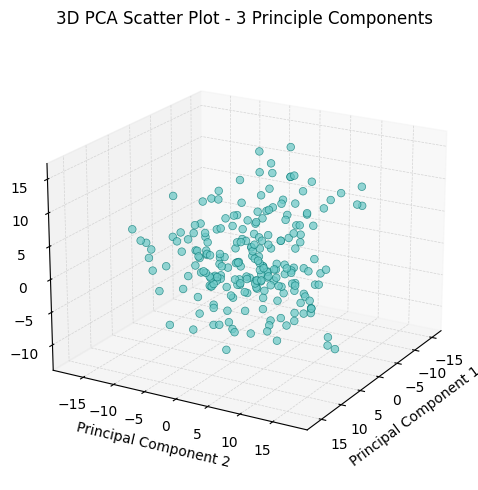

In [15]:
N_COMPONENTS = 3

pca = PCA(n_components=N_COMPONENTS)
pca_result = pca.fit_transform(data_scaled)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
           c=LIGHT_GREEN, edgecolor=GREEN, linewidth=0.5, s=30,
           alpha=0.75)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D PCA Scatter Plot - 3 Principle Components")

ax.xaxis._axinfo["grid"].update(color = "lightgrey", linestyle="--", linewidth=0.5)
ax.yaxis._axinfo["grid"].update(color = "lightgrey", linestyle="--", linewidth=0.5)
ax.zaxis._axinfo["grid"].update(color = "lightgrey", linestyle="--", linewidth=0.5)

ax.view_init(elev=20, azim=30) 

plt.tight_layout()
plt.show()

Now, we are going to use a [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html). Pairplot's are great for higher number of components. They let us plot the pairwise relationships in the dataset. It is in fact simply the scatter plot from before but for every combination of one component to another component.  

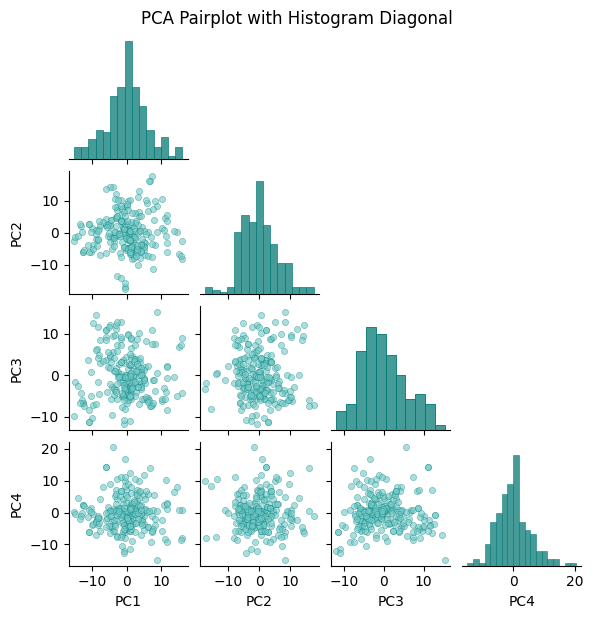

In [16]:
N_COMPONENTS = 4

pca = PCA(n_components=N_COMPONENTS)
pca_result = pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(pca_result, columns=[f"PC{i}" for i in range(1, N_COMPONENTS+1)])

sns.pairplot(pca_df, height=1.5, corner=True, 
             plot_kws={'color': LIGHT_GREEN, 'edgecolor': GREEN, 'alpha': 0.6, 's': 20}, 
             diag_kws={'color': GREEN, 'edgecolor': GREEN, 'fill': True})

plt.suptitle("PCA Pairplot with Histogram Diagonal", y=1.02, fontsize=12)
plt.show()

We can also do pairplots in 3D. This is essentially the same we did above for 3 components but we rather do it now for all 3D combinations of our components. Below, this means we have four 3D pairplots. 

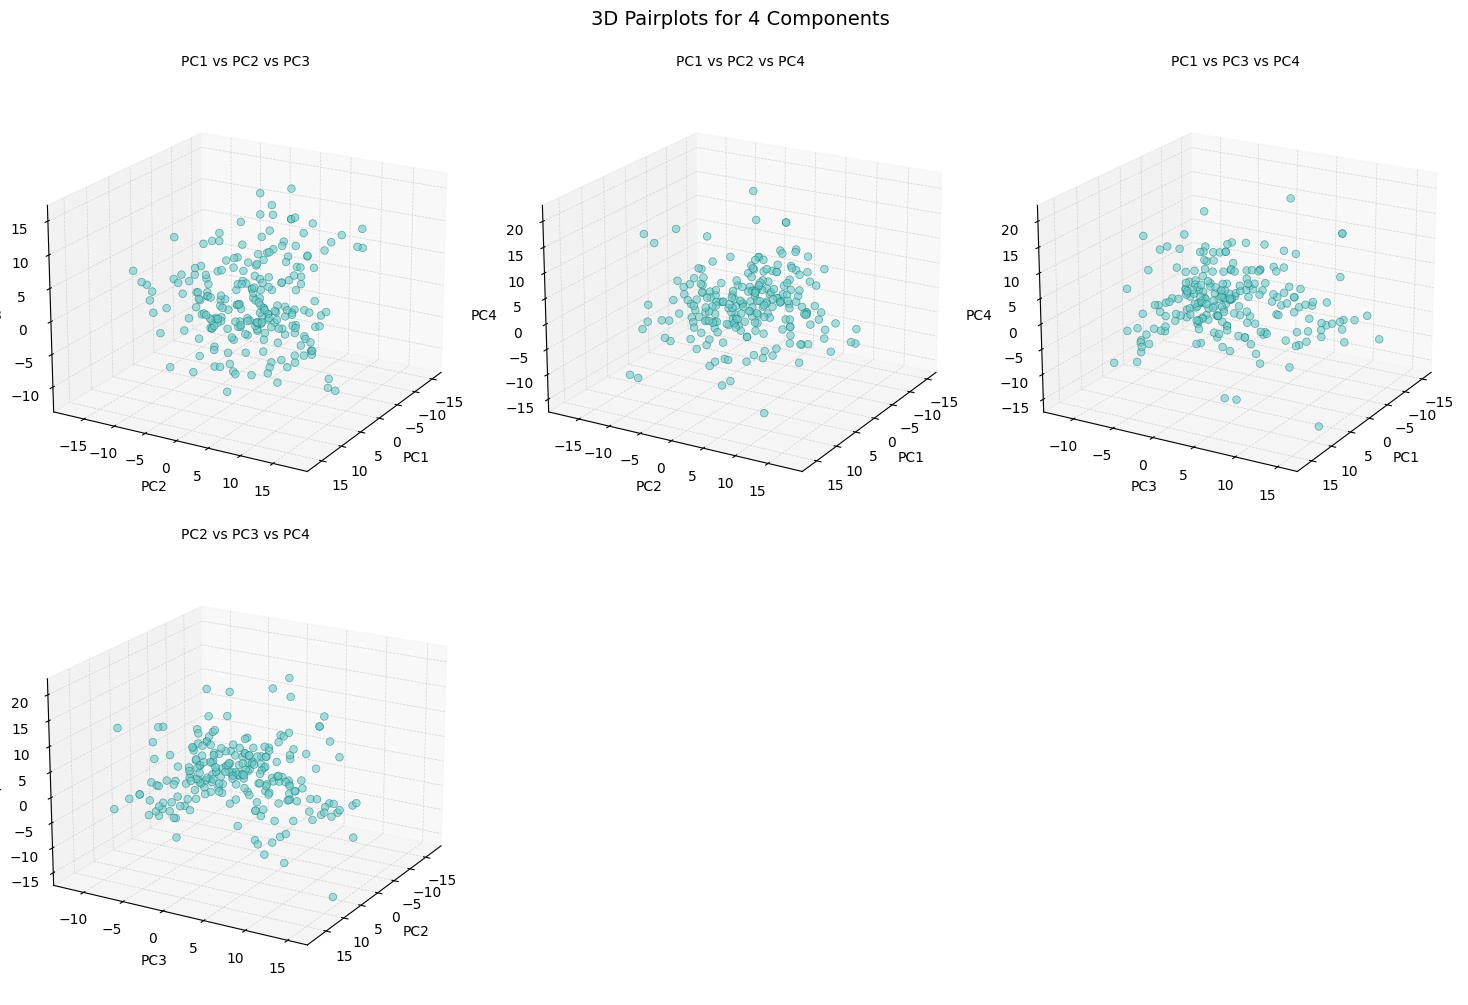

In [17]:
# All 3D combinations of components
component_combinations = list(combinations(pca_df.columns, 3))

fig = plt.figure(figsize=(15, 10))
for idx, (x, y, z) in enumerate(component_combinations):
    ax = fig.add_subplot(2, 3, idx + 1, projection='3d')
    ax.scatter(pca_df[x], pca_df[y], pca_df[z],
               c=LIGHT_GREEN, edgecolor=GREEN, s=30, alpha=0.6, linewidth=0.5)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    ax.set_title(f"{x} vs {y} vs {z}", fontsize=10)
    ax.view_init(elev=20, azim=30)

    ax.xaxis._axinfo["grid"].update(color = "lightgrey", linestyle="--", linewidth=0.5)
    ax.yaxis._axinfo["grid"].update(color = "lightgrey", linestyle="--", linewidth=0.5)
    ax.zaxis._axinfo["grid"].update(color = "lightgrey", linestyle="--", linewidth=0.5)

plt.suptitle(f"3D Pairplots for {N_COMPONENTS} Components", fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

We can also split by our target column which is called `Label`.

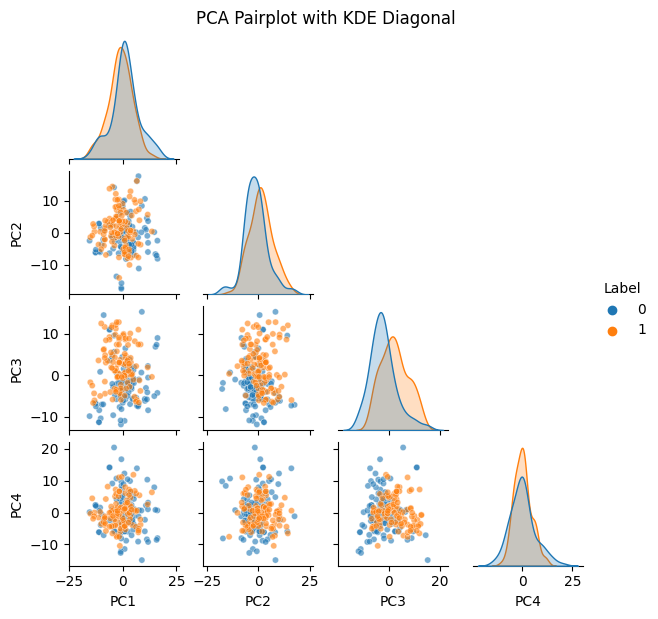

In [18]:
pca_df['Label'] = data['Label']

sns.pairplot(pca_df, height=1.5, corner=True, hue='Label',
             plot_kws={'alpha': 0.6, 's': 20})

plt.suptitle("PCA Pairplot with KDE Diagonal", y=1.02, fontsize=12)
plt.show()

The KDE diagonal plots reveal that **PC3** shows a more distinct separation between the distributions of labels `0` and `1` compared to the other principal components, indicating that PC3 captures the most significant variance between the two groups. 

We can also visualize how strongly a feature contributes to a specific principal component (PC). Think of this as feature importances per PC. A common term for this is **<span style="color:#ba4e00">loading</span>**. It refers to the weights or coefficients of the original features for each PC. In mathematical terms, the loadings are the values in the eigenvectors of the covariance matrix, scaled appropriately. The magnitude (absolute value) of a loading indicates the strength of the feature's contribution to the PC. 

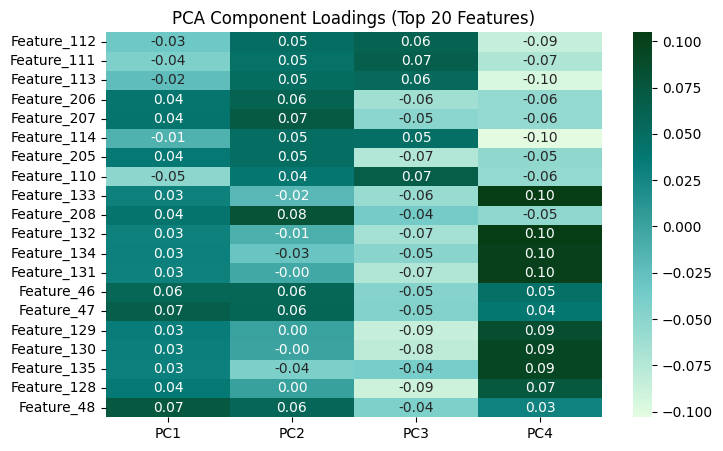

In [19]:
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_green_gradient",
    ["#e3fce1", LIGHT_GREEN, GREEN, "#073d15"]
)

# Find top-N contributing features per component
top_n = 20
pca = PCA(n_components=N_COMPONENTS)
pca.fit(data_scaled)

loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f"PC{i+1}" for i in range(4)], 
    index=[f"Feature_{i+1}" for i in range(data.shape[1])]
)

# Get top-N absolute loadings for each principal component
top_features = loadings.abs().sum(axis=1).nlargest(top_n).index
filtered_loadings = loadings.loc[top_features]

plt.figure(figsize=(8, 5))
sns.heatmap(filtered_loadings, annot=True, cmap=custom_cmap, fmt=".2f")
plt.title(f"PCA Component Loadings (Top {top_n} Features)")
plt.show()

There are multiple features (`133`, `134`, `132`, `131`, `135`, `130`) in PC4 which have a strong positive contribution to the variance explained by PC4. Since we also see similar loadings for these features for the other PCs it could inidcate that those features are highly correlated. Let's investigate this.

In [20]:
data[[f'Feature_{i}' for i in ['133', '134', '132', '131', '135', '130']]].corr()

,Feature_133,Feature_134,Feature_132,Feature_131,Feature_135,Feature_130
Feature_133,1.000000,0.983890,0.985490,0.945166,0.933594,0.882166
Feature_134,0.983890,1.000000,0.940455,0.875536,0.982037,0.792140
Feature_132,0.985490,0.940455,1.000000,0.986332,0.863573,0.946526
Feature_131,0.945166,0.875536,0.986332,1.000000,0.777505,0.986156
Feature_135,0.933594,0.982037,0.863573,0.777505,1.000000,0.677957
Feature_130,0.882166,0.792140,0.946526,0.986156,0.677957,1.000000


Indeed, all these features are highly correlated with one another which is the reason why their loadings are nearly or exactly equal.

Let's look at the same pairpot as before but with KDE plots on the diagonal instead of histograms. We also directly increase the number of Principle Components. 

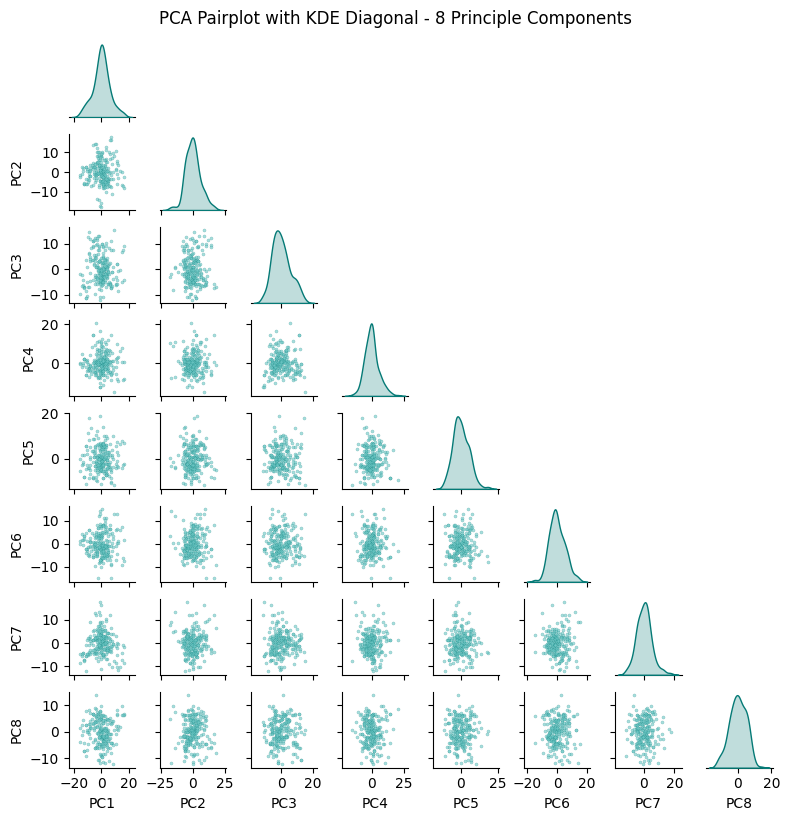

In [21]:
N_COMPONENTS = 8

pca = PCA(n_components=N_COMPONENTS)
pca_result = pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i}' for i in np.arange(1, N_COMPONENTS+1)])

g = sns.pairplot(
    pca_df,
    height=1.0,
    corner=True,
    diag_kind="kde",
    plot_kws={'color': LIGHT_GREEN, 'edgecolor': GREEN, 'alpha': 0.6, 's': 5},
    diag_kws={'color': GREEN, 'linewidth': 1}
)
plt.suptitle(f"PCA Pairplot with KDE Diagonal - {N_COMPONENTS} Principle Components", y=1.02, fontsize=12)
plt.show()

For our dataset we see **no linear correlation between components**. The scatterplots show no strong patterns or trends between the PCs, indicating they are uncorrelated. This is, however, expected since PCA constructs components to be orthogonal (uncorrelated) to one another. A pairplot of principal components is more about understanding the structure of the data in the reduced space, including clusters, distributions, outliers, and potential nonlinear relationships. It provides a visual, intuitive layer of insight into the results of PCA.

Once again, we can split by the target column `Label` to investigate the differences for each of the binary label class.

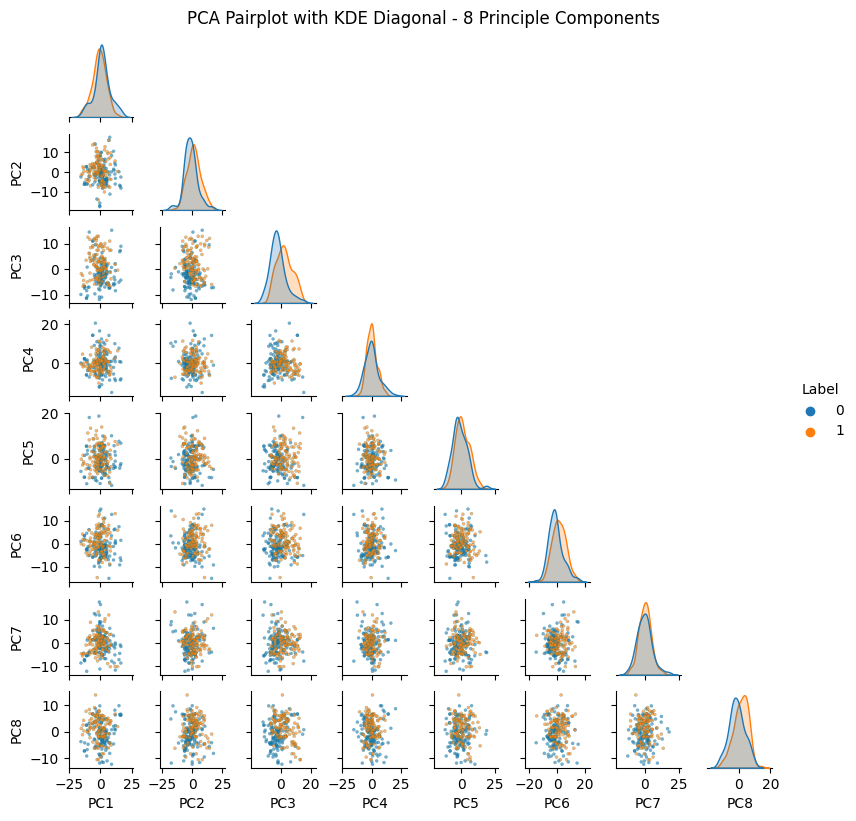

In [22]:
N_COMPONENTS = 8

pca = PCA(n_components=N_COMPONENTS)
pca_result = pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i}' for i in np.arange(1, N_COMPONENTS+1)])
pca_df['Label'] = data['Label']

g = sns.pairplot(
    pca_df,
    height=1.0,
    hue='Label',
    corner=True,
    diag_kind="kde",
    plot_kws={'color': LIGHT_GREEN, 'edgecolor': GREEN, 'alpha': 0.6, 's': 5},
    diag_kws={'color': GREEN, 'linewidth': 1}
)
plt.suptitle(f"PCA Pairplot with KDE Diagonal - {N_COMPONENTS} Principle Components", y=1.02, fontsize=12)
plt.show()

Now, in addition to PC3 from before, also **PC6** and **PC8** show a more distinct separation between the distributions of labels `0` and `1`, indicating that they capture the most significant variance between the two groups.

## Why Use PCA in XAI?🤔

In Explainable AI, PCA helps to:
- ✅**Simplify Interpretability**: Reducing dimensionality allows for clearer visualizations and understanding of data patterns.
- ✅**Feature Importance**: By identifying which components contribute the most to variance, you can infer which features are most impactful.
- ✅**Preprocessing**: Simplifying data can improve model performance and training efficiency for explainable models.

# 🌀t-SNE
⚡**TL;DR**⚡

> ***<span style="color:#ba4e00">t-distributed stochastic neighbor embedding</span>*** = t-SNE

Involves constructing a lower dimensional representation where similar data points are placed closer together. 
- Should be used to emphasize visualization, reveal local patterns and clusters.

**Intuition**
> [t-SNE](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html) compresses high-dimensional data into a lower-dimensional space by preserving local relationships (e.g., clusters or neighborhoods). It achieves this by ensuring points close in the high-dimensional space remain close in the low-dimensional space, while pushing dissimilar points further apart using the heavy-tailed t-distribution.

In [23]:
from sklearn.manifold import TSNE

In [24]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

## How t-SNE Works & The Mathematics Behind It🧩🧮 
**Objective**
> t-SNE is a dimensionality reduction technique desgined for **visualizing high-dimensional data** in 2D or 3D while preserving the **local structure of the data**. It minimizes the difference between pairwise similarities in high-dimensional and low-dimensional spaces.

The steps of t-SNE are:

1️⃣ **Compute Pairwise Similarities in High-Dimensional Space**
   
- Models similarities between points in the high-dimensional space using [conditional probabilities](https://en.wikipedia.org/wiki/Conditional_probability) that reflect the [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) of a data point being a neighbor of another.

For a pair of points $x_i$ and $x_j$, the similarity is modeled as a Gaussian distribution:
$$
    P_{j|i} = \frac{\frac{\exp(-|| x_i - x_j ||^2)}{2\sigma_i^2}}{\sum_{k \neq i}\frac{\exp(-|| x_i - x_k ||^2)}{2\sigma_i^2}}
$$
- $P_{j|i}$: Probability that $x_j$ is a neighbor of $x_i$.
- $\sigma_i$: [Perplexity](https://en.wikipedia.org/wiki/Perplexity)-related parameter controlling the bandwidth of the Gaussian distribution.

The joint probability $P_{ij}$ is the symmetrized:
$$
    P_{ij} = \frac{P_{j|i} + P_{i|j}}{2n}
$$
- $P_{ij}$: Symmetric similarity measure in high-dimensional space.

2️⃣ **Initialize Low-Dimensional Embedding**

- Starts by randomly initializing the data points in the low-dimensional space, represented as $y_i \in \mathbb{R}^d$, where $d$ is typically $2$ or $3$.
  
3️⃣ **Compute Pairwise Similarities in Low-Dimensional Space**
    
- In the low-dimensional space, t-SNE models similarities using a [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) with one degree of freedom (equivalent to a [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution)):
$$
    Q_{ij} = \frac{(1 + \exp(-|| y_i - y_j ||^2))^{-1}}{\sum_{k \neq i}(1 + \exp(-|| x_i - x_k ||^2))^{-1}}
$$
- $Q_{ij}$: (Joint) probability that points $y_i$ and $y_j$ are neighbors in the low-dimensional space.

Note, that the heavy-tailed nature of the t-distribution ensures that dissimilar points (far apart in high-dimensional space) are not pulled together in the low-dimensional embedding.

4️⃣ **Minimize the Kullback-Leibler Divergence**
    
- Optimizes the layout by minimizing the [**Kullback-Leibler (KL) divergence**](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the high-dimensional probabilities $P_{ij}$ and the low-dimensional probabilities $Q_{ij}$:
  
$$
    C = \sum_{i \neq j}P_{ij}\log \frac{P_{ij}}{Q_{ij}}
$$
- The optimization is performed using [**gradient descent**](https://en.wikipedia.org/wiki/Gradient_descent)

5️⃣ **Update Low-Dimensional Points**

- During optimization, points in the low-dimensional space are updated iteratively to reduce the cost function:
$$
    y_i^{(t+1)} = y_i^{(t)} + \eta\frac{\partial C}{\partial y_i}
$$
- $\eta$: Learning rate.
- The updated aim to make $Q_{ij}$ mathc $P_{ij}$ as closely as possible.

There are some **key concepts** one should keep in mind:
1. **Perplexity**: A hyperparameter controlling the balance between local and global structure: It determines the effective number of neighbors considered for each point.
2. **Crowding Problem**: The low-dimensional space struggles to represent both small and large pairwise distances accurately. Using a t-distribution mitigates this by emphasizing local structure.
3. **KL Divergence**: Penalizes mismatches between pairwise similarities in high- and low-dimensional spaces. A lower $C$ indicates better alignment of local structures.

In [25]:
N_COMPONENTS = 2

tsne = TSNE(n_components=N_COMPONENTS, random_state=42, perplexity=30, n_iter=1_000)
tsne_result = tsne.fit_transform(data_scaled)

print(tsne_result[:5])

[[-1.7827828 -6.6459026]
 [ 1.9076993 -1.6515276]
 [-3.9150643 -6.2253156]
 [-4.5392833 -2.0440874]
 [-3.6477485 -2.7011478]]


## Visualization Techniques🔍

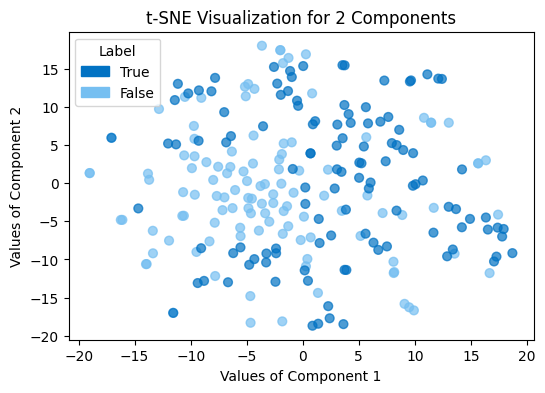

In [26]:
plt.figure(figsize=(6, 4))

colors = np.where(data['Label'], BLUE, LIGHT_BLUE)

plt.scatter(tsne_result[:, 0], 
            tsne_result[:, 1], 
            c=colors, 
            s=40, 
            alpha=0.7)

plt.xlabel('Values of Component 1')
plt.ylabel('Values of Component 2')
plt.title(f"t-SNE Visualization for {N_COMPONENTS} Components")

plt.legend(handles=[
    mpatches.Patch(color=BLUE, label='True'), 
    mpatches.Patch(color=LIGHT_BLUE, label='False')
], title="Label", loc="best")

plt.show()

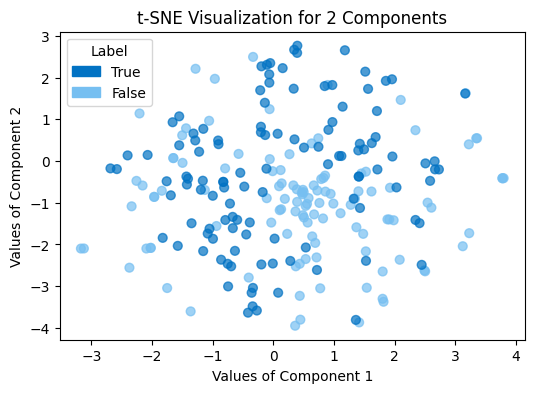

In [27]:
N_COMPONENTS = 2

tsne = TSNE(n_components=N_COMPONENTS, random_state=RANDOM_STATE, perplexity=100, n_iter=1_000)
tsne_result = tsne.fit_transform(data_scaled)

plt.figure(figsize=(6, 4))

colors = np.where(data['Label'], BLUE, LIGHT_BLUE)

plt.scatter(tsne_result[:, 0], 
            tsne_result[:, 1], 
            c=colors, 
            s=40, 
            alpha=0.7)

plt.xlabel('Values of Component 1')
plt.ylabel('Values of Component 2')
plt.title(f"t-SNE Visualization for {N_COMPONENTS} Components")

plt.legend(handles=[
    mpatches.Patch(color=BLUE, label='True'), 
    mpatches.Patch(color=LIGHT_BLUE, label='False')
], title="Label", loc="best")

plt.show()

Let's try to understand how the `perplexity` and the `n_iter` influence the results of t-SNE.

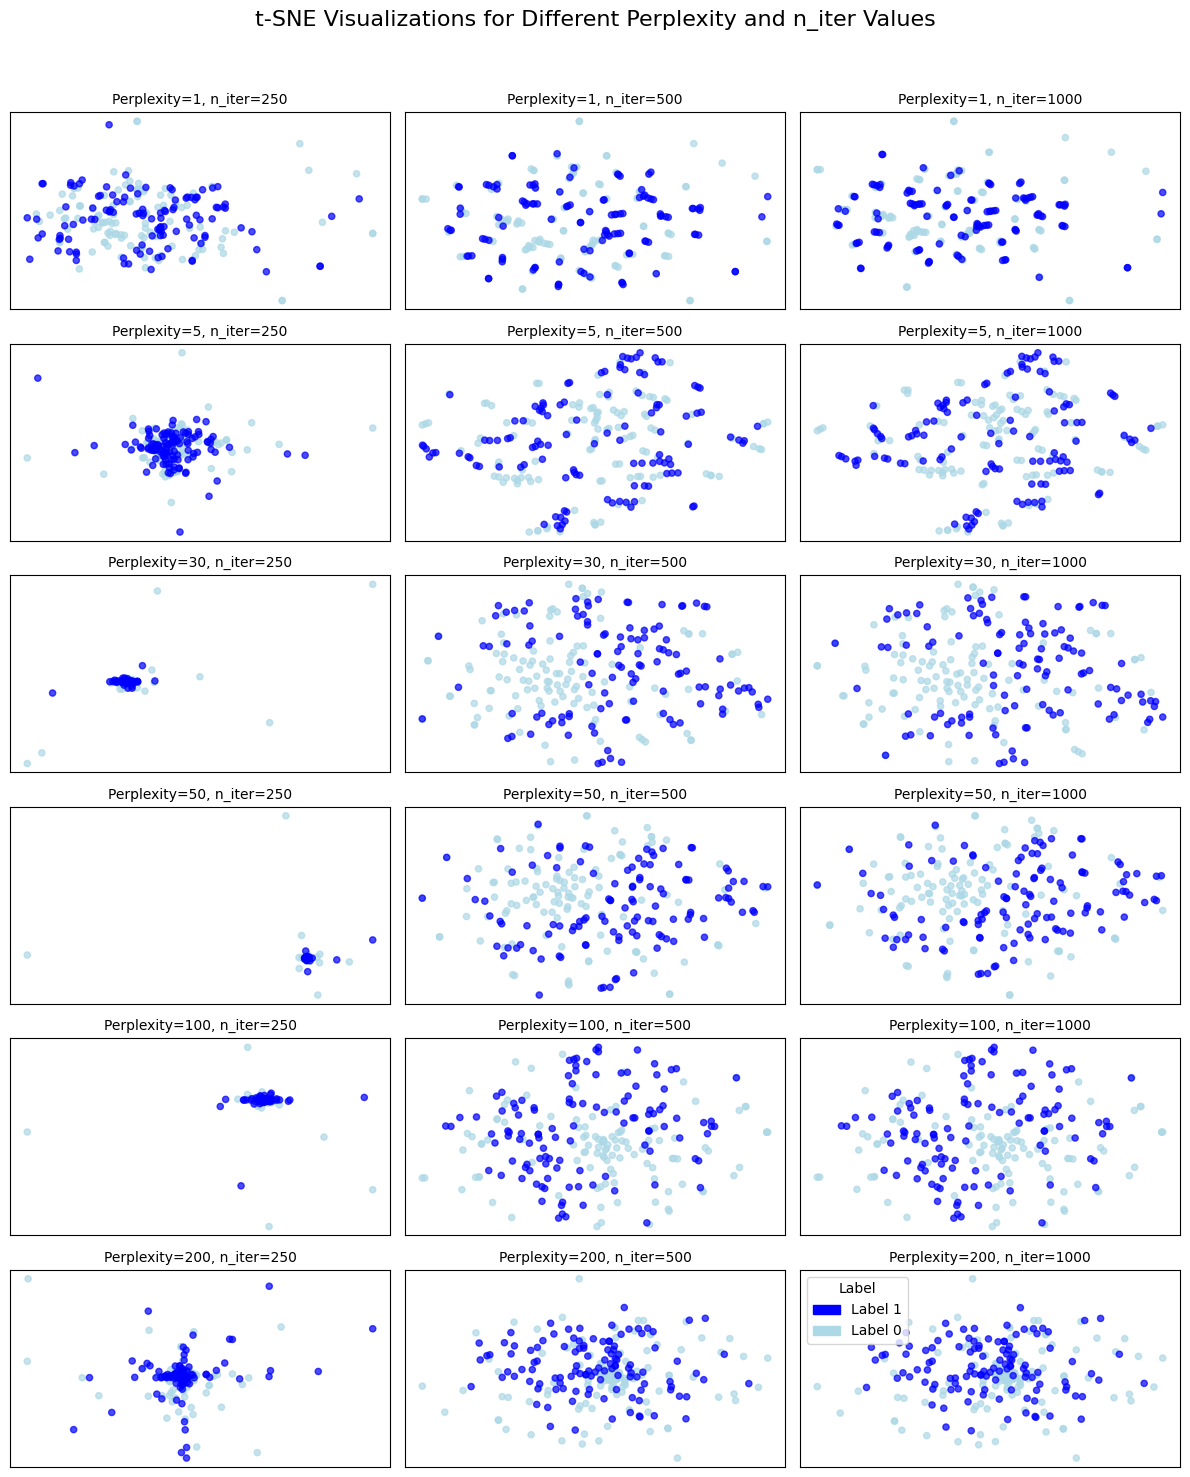

In [28]:
perplexity_values = [1, 5, 30, 50, 100, 200]
n_iter_values = [250, 500, 1_000]

fig, axes = plt.subplots(len(perplexity_values), len(n_iter_values), figsize=(12, 16))
fig.suptitle("t-SNE Visualizations for Different Perplexity and n_iter Values", y=0.92, fontsize=16)

for i, perplexity in enumerate(perplexity_values):
    for j, n_iter in enumerate(n_iter_values):
        tsne = TSNE(n_components=2, random_state=RANDOM_STATE, 
                    perplexity=perplexity, n_iter=n_iter, init='pca')
        tsne_result = tsne.fit_transform(data_scaled)

        colors = np.where(data['Label'], 'blue', 'lightblue')

        ax = axes[i, j]
        ax.scatter(tsne_result[:, 0], tsne_result[:, 1], c=colors, s=20, alpha=0.7)
        ax.set_title(f"Perplexity={perplexity}, n_iter={n_iter}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

handles = [
    mpatches.Patch(color='blue', label='Label 1'),
    mpatches.Patch(color='lightblue', label='Label 0')
]
axes[-1, -1].legend(handles=handles, title="Label", loc="best")

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

In [29]:
N_COMPONENTS = 3

tsne = TSNE(n_components=N_COMPONENTS, random_state=42, perplexity=30, n_iter=1_000)
tsne_result = tsne.fit_transform(data_scaled)

print(tsne_result[:5])

[[ -7.3367405  17.891357  -11.220637 ]
 [ -6.733265  -12.812531   20.928747 ]
 [ -0.6120919   6.1720066 -25.445831 ]
 [ -6.28631   -12.63684   -11.036221 ]
 [  7.5786777 -12.759634   -3.3696132]]


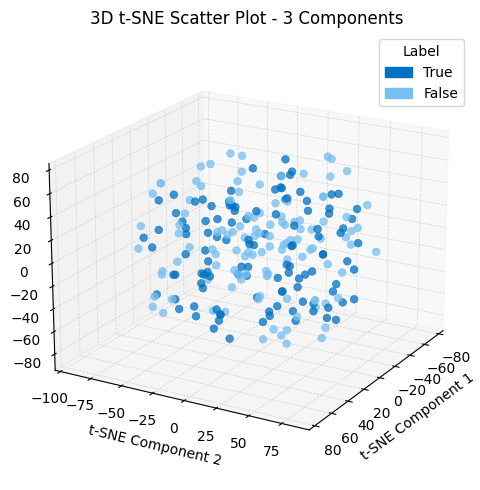

In [30]:
colors = np.where(data['Label'], BLUE, LIGHT_BLUE)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], 
                     c=colors, linewidth=0.5, s=30, alpha=0.75)

ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")
ax.set_title("3D t-SNE Scatter Plot - 3 Components")

# Customize grid lines
ax.xaxis._axinfo["grid"].update(color="lightgrey", linestyle="--", linewidth=0.5)
ax.yaxis._axinfo["grid"].update(color="lightgrey", linestyle="--", linewidth=0.5)
ax.zaxis._axinfo["grid"].update(color="lightgrey", linestyle="--", linewidth=0.5)

ax.legend(handles=[
    mpatches.Patch(color=BLUE, label='True'), 
    mpatches.Patch(color=LIGHT_BLUE, label='False')
], title="Label", loc="best")

ax.view_init(elev=20, azim=30)

plt.tight_layout()
plt.show()

## Why Use t-SNE in XAI?🤔

In Explainable AI, t-SNE helps to:
- ✅**Visualize High-Dimensional Data**: t-SNE excels at creating 2D or 3D maps that reveal clusters, separations, and patterns, making it easier to interpret complex datasets.
- ✅**Identify Local Structure**: By preserving local neighborhoods, t-SNE helps uncover relationships and subgroups in the data, aiding in understanding model decisions.
- ✅**Clustering Validation**: It allows to visually validate whether the clusters formed by a model align with meaningful patterns in the data.

# 🌐UMAP
⚡**TL;DR**⚡

> ***<span style="color:#ba4e00">Uniform manifold approximation and projection</span>*** = UMAP

Uses manifold learning and non-linear dimensionality reduction technique to understand the underlying structure or shape of the data. Focuses on capturing complex non-linear relationships in the data. 
- Should be used to preserve local structure and handle complex non-linear relationships.

In [31]:
import umap
import umap.umap_ as umap

In [32]:
N_COMPONENTS = 2

umap_model = umap.UMAP(n_components=N_COMPONENTS, random_state=42)
umap_result = umap_model.fit_transform(data_scaled)
umap_result[:5]

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


array([[ 0.91313326, 10.763724  ],
       [ 0.21547174, 10.45159   ],
       [ 0.7996187 , 10.972875  ],
       [ 0.7577187 , 10.02818   ],
       [ 0.07665563, 10.611515  ]], dtype=float32)

## How UMAP Works & The Mathematics Behind It🧩🧮 
**Objective**
> UMAP reduces high-dimensional data into lower dimensions (usually 2D or 3D) while preserving both local and some global structure. It is faster and more versatile than t-SNE.

The steps of UMAP are:

1️⃣ **Construct the High-Dimensional Graph**

- Starts by calculating the *local relationships* (neighborhoods) of each data point in high-dimensional space.

The relationship between $x_i$ and $x_j$ is modeled using a [*fuzzy set*](https://en.wikipedia.org/wiki/Fuzzy_set#:~:text=In%20mathematics%2C%20fuzzy%20sets%20(also,the%20classical%20notion%20of%20set.): 
$$
    p_{ij} = \exp( -\frac{\max(0, d(x_i, x_j) - \rho_i)}{-\sigma_i} )
$$
- $d(x_i, x_j)$: Distance between points.
- $\rho_i$: Minimum distance to the nearest neighbor (ensures connectivity).
- $\sigma_i$: Scaling parameter, optimized to match a *perplexity-like measure*.

The result of this step is a weighted graph where edges reflect neighborhood similarities.

2️⃣ **Optimize the Low-Dimensional Embedding**

- In the low-dimensional space, UMAP models relationships using a *simpler distribution* (e.g., similar to a Laplacian curve):

$$
    q_{ij} = \frac{1}{1 + d(y_i, y_j)^2}
$$

- $q_{ij}$: Pairwise similarities in the low-dimensional space.

3️⃣ **Align High- and Low-Dimensional Relationships**

- Minimizes the difference between the high-dimensional graph $p_{ij}$ and the low-dimensional graph $q_{ij}$.

It does so by *optimizing a cross-entropy loss*:
$$
    C = \sum_{i \neq j}\Big[ p_{ij}\log\frac{p_{ij}}{q_{ij}} + (1 - p_{ij})\log\frac{1 - p_{ij}}{1 - q_{ij}} \Big]
$$

This ensures that similar points stay close together while distant points remain far apart in the low-dimensional embedding, same as for t-SNE from the previous chapter. 

We try to make the low-dimensional map reflects the high-dimensional neighborhood structure. We can think of this as trying to flatten a crumpled-up piece of paper where we want to preserve the local details (folds and creases) while fitting everything onto a flat surface (2D). 

4️⃣ **Iterative Optimization via Gradient Descent**

- The positions of the points in the low-dimensional space are updated iteratively:

$$
    y_i^{t+1} = y_i^{(t)} - \eta\frac{\partial C}{\partial y_i}
$$

- $y_i$: Low-dimensional embedding of the data point.
- $\eta$: Learning rate.

Here, we gradually adjust the positions of the points in 2D or 3D space to minimize the misalignment cost. This ensures the low-dimensional embedding reflects the relationships from the original space. 

There are some **key concepts** one should keep in mind: 
1. **Perplexity-Like Scaling**: UMAP automatically tunes its parameter $\sigma_i$ for each point to balance local and global structure, similar to perplexity in t-SNE.
2. **Local and Global Structure**: UMAP captures local clusters and some global trends, making it more versatile than t-SNE for data exploration.
3. **Fuzzy Graphs**: The fuzzy high-dimensional graph preserves nuanced relationships that are smoothed into the low-dimensional embedding.

## Visualization Techniques🔍

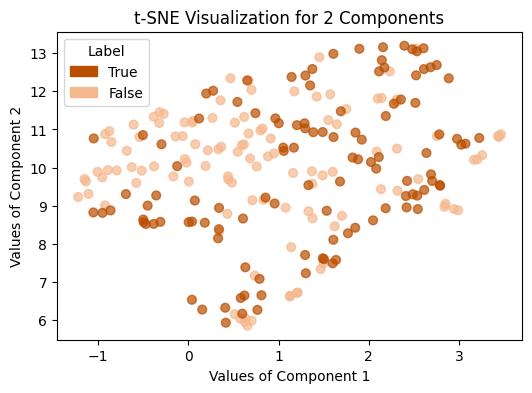

In [33]:
plt.figure(figsize=(6, 4))

colors = np.where(data['Label'], BROWN, LIGHT_BROWN)

plt.scatter(umap_result[:, 0], 
            umap_result[:, 1], 
            c=colors, 
            s=40, 
            alpha=0.7)

plt.xlabel('Values of Component 1')
plt.ylabel('Values of Component 2')
plt.title(f"t-SNE Visualization for {N_COMPONENTS} Components")

plt.legend(handles=[
    mpatches.Patch(color=BROWN, label='True'), 
    mpatches.Patch(color=LIGHT_BROWN, label='False')
], title="Label", loc="best")

plt.show()

In [34]:
N_COMPONENTS = 3

umap_model = umap.UMAP(n_components=N_COMPONENTS, random_state=42)
umap_result = umap_model.fit_transform(data_scaled)
umap_result[:5]

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


array([[ 3.5802038 , 18.041016  , -0.9076526 ],
       [ 2.8381677 , 18.360657  ,  0.05963825],
       [ 3.643596  , 18.272966  , -0.69980574],
       [ 2.9084787 , 17.848978  , -0.13307671],
       [ 2.6892636 , 18.241516  , -0.3243415 ]], dtype=float32)

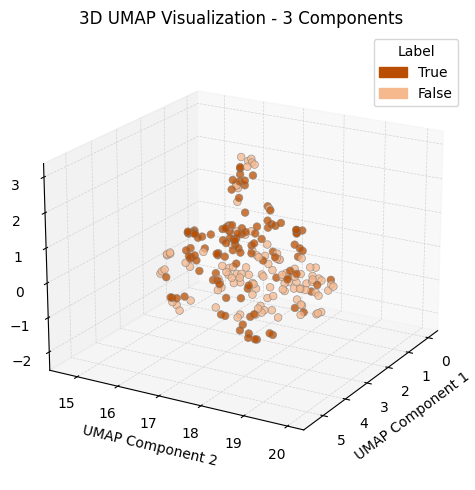

In [35]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(umap_result[:, 0], umap_result[:, 1], umap_result[:, 2], 
                     c=colors, edgecolor='gray', linewidth=0.5, s=30, alpha=0.75)

ax.set_xlabel("UMAP Component 1")
ax.set_ylabel("UMAP Component 2")
ax.set_zlabel("UMAP Component 3")
ax.set_title(f"3D UMAP Visualization - {N_COMPONENTS} Components")

ax.set_xlim([umap_result[:, 0].min() - 1, umap_result[:, 0].max() + 1])
ax.set_ylim([umap_result[:, 1].min() - 1, umap_result[:, 1].max() + 1])
ax.set_zlim([umap_result[:, 2].min() - 1, umap_result[:, 2].max() + 1])

ax.xaxis._axinfo["grid"].update(color="lightgrey", linestyle="--", linewidth=0.5)
ax.yaxis._axinfo["grid"].update(color="lightgrey", linestyle="--", linewidth=0.5)
ax.zaxis._axinfo["grid"].update(color="lightgrey", linestyle="--", linewidth=0.5)

ax.legend(handles=[
    mpatches.Patch(color=BROWN, label='True'), 
    mpatches.Patch(color=LIGHT_BROWN, label='False')
], title="Label", loc="best")

ax.view_init(elev=20, azim=30)

plt.tight_layout()
plt.show()

## Why Use UMAP in XAI?🤔

In Explainable AI, UMAP helps to:
- ✅**Preserve Both Local and Global Structure**: Balances capturing local neighborhood relationships and global patterns, enabling a holistic view of the data.
- ✅**Scalable Interpretability**: Is faster and handles larger datasets than t-SNE, making it suitable for XAI workflows with big data.
- ✅**Feature Discovery**: Can help uncover relationships or hidden structures in data, making it easier to explain model predictions or behaviors.

---


💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

Please **UPVOTE** if you enjoyed this notebook 🙏